In [163]:
import glob
import skimage.io as io
import numpy as np
import cv2
import commonfunctions as cf
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize, downscale_local_mean

## Load the vehicle and non-vehicle images

In [16]:
vehicles_path = glob.glob("./train data/vehicles/**/*.png", recursive = True)
non_vehicles_path = glob.glob("./train data/non-vehicles/**/*.png", recursive = True)
vehicles = [io.imread(vehicle_path) for vehicle_path in vehicles_path]
non_vehicles = [io.imread(non_vehicle_path) for non_vehicle_path in non_vehicles_path]

In [3]:
print("The number of vehicle images " + str(len(vehicles)))
print("The number of non vehicle images " + str(len(non_vehicles)))
print("The shape of a vehicle image " + str(np.shape(vehicles)[1:]))
print("The shape of a non vehicle image " + str(np.shape(non_vehicles)[1:]))

The number of vehicle images 8792
The number of non vehicle images 8968
The shape of a vehicle image (64, 64, 3)
The shape of a non vehicle image (64, 64, 3)


In [158]:
#Color Augmentation 
#Brightness
#if value of a pixel was between [0-1] we can allow a pixel with a float value
#if value of a pixel was between [0-255] we should allow only a pixel with an int value, to be able to draw properly
def apply_brightness_augmentation(images, brightness_value):
    brighted_images = images.copy()
    brighted_images = brighted_images/255
    brighted_images += brightness_value
    
    leftMin = brightness_value
    leftMax = 1 + brightness_value
    rightMin = brightness_value
    rightMax = 1
    
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = (brighted_images - leftMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    brighted_images = rightMin + (valueScaled * rightSpan)
    return brighted_images

(38, 38, 3)


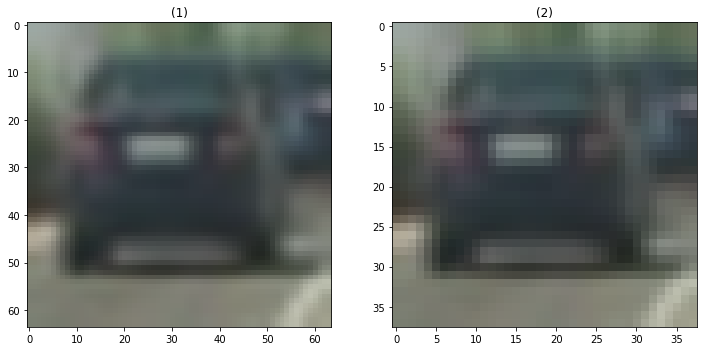

In [180]:

image_rescaled = rescale(vehicles[0], 0.6, anti_aliasing=False, multichannel=True)
print(image_rescaled.shape)
cf.show_images([vehicles[0], image_rescaled])

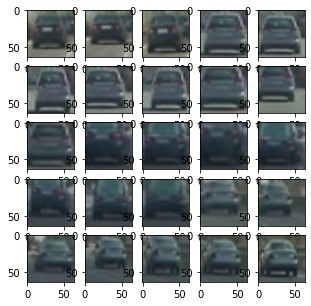

In [121]:
def show_samples(images, grid_size):
    fig = plt.figure(figsize=(grid_size, grid_size))
    patch_images = images[0:grid_size*grid_size+1]
    for i in range(1,grid_size*grid_size+1):
        fig.add_subplot(grid_size,grid_size, i)
        plt.imshow(patch_images[i-1])
    plt.show()
    
show_samples(vehicles, 5)

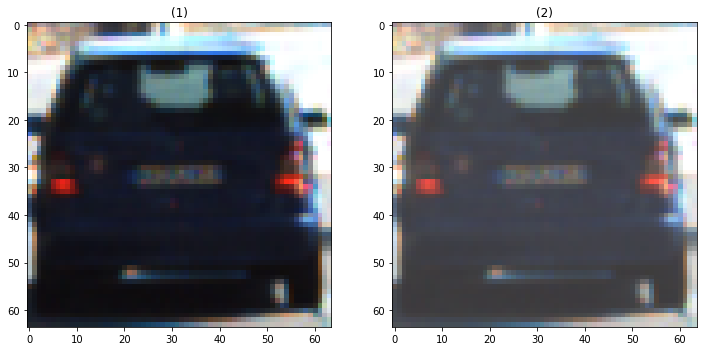

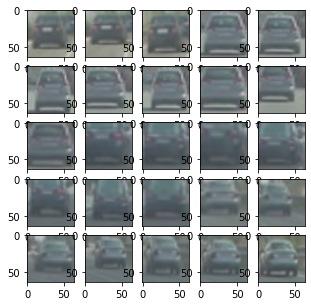

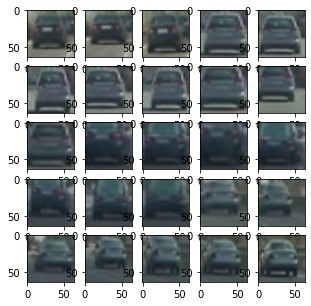

In [162]:

brightness_value = 50/255
brighted_vehicles = apply_brightness_augmentation(np.array(vehicles), brightness_value)
brighted_non_vehicles = apply_brightness_augmentation(np.array(non_vehicles), brightness_value)

cf.show_images([vehicles[4000], brighted_vehicles[4000]])
show_samples(brighted_vehicles, 5)
show_samples(vehicles, 5)


In [182]:
vehicles_hog_features = []
non_vehicles_hog_features = []
for vehicle in vehicles:
    hog_features= hog(vehicle, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False, feature_vector=True, multichannel=None)
    vehicles_hog_features.append(hog_features)


for non_vehicle in non_vehicles:
    hog_features= hog(non_vehicle, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys', visualize=False, transform_sqrt=False, feature_vector=True, multichannel=None)
    non_vehicles_hog_features.append(hog_features)


In [70]:
vehicles = np.array(vehicles)
vehicles_hog_features = np.array(vehicles_hog_features)

non_vehicles = np.array(non_vehicles)
non_vehicles_hog_features = np.array(non_vehicles_hog_features)


In [181]:
print("size of the vehicles hog features = " + str(len(vehicles_hog_features[0])))
print("size of the  non vehicles hog features = " + str(len(non_vehicles_hog_features[0])))

NameError: name 'vehicles_hog_features' is not defined

In [94]:
x=np.vstack((vehicles_hog_features,non_vehicles_hog_features))
y=np.hstack((np.ones(len(vehicles)),np.zeros(len(non_vehicles))))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
svc = LinearSVC()
svc.fit(x_train, y_train)


LinearSVC()